In [61]:
import pathlib
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


In [46]:
# importing preprocessed data, ready for ML
X_train = pd.read_csv("data/X_train.csv", index_col="Id")
X_valid = pd.read_csv("data/X_valid.csv", index_col="Id")
X_test = pd.read_csv("data/X_test.csv", index_col="Id")

y_train = pd.read_csv("data/y_train.csv", index_col="Id")
y_valid = pd.read_csv("data/y_valid.csv", index_col="Id")


In [47]:
# change the "SalePrice" to its log since that's what matters in the competition
y_train["SalePrice"] = np.log(y_train["SalePrice"] + 1.)
y_valid["SalePrice"] = np.log(y_valid["SalePrice"] + 1.)

y_valid.head()

,SalePrice
Id,
493,12.059809
66,12.666660
890,11.915058
1174,12.208575
1207,11.580593


In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid.values, y_valid.values))

In [49]:
# for feat, targ in train_dataset.take(5):
#   print ('Features: {}, Target: {}'.format(feat, targ))

In [50]:
FEATURES = 32
N_TRAIN = len(X_train)
N_VALID = len(X_valid)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 200
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# enable caching
train_dataset = train_dataset.cache()
valid_dataset = valid_dataset.cache()

In [51]:
# set Batch size
valid_dataset = valid_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [52]:
# training procedure

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [53]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [54]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.RootMeanSquaredError()])

  model.summary()

  history = model.fit(
    train_dataset,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=valid_dataset,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

In [55]:
# to check if everything is working correctly
tiny_model = keras.Sequential([
  layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
  layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:72.4435,  root_mean_squared_error:8.5114,  val_loss:55.3623,  val_root_mean_squared_error:7.4406,  
...................................................................................................
Epoch: 100, loss:0.5078,  root_mean_squared_error:0.7126,  val_loss:0.5215,  val_root_mean_squared_error:0.7221,  
....................................................................................................
Epoch: 200, loss:0.3259,  root_mean_squared_error:0.5709,  val_loss:0.2993,  val_root_

In [59]:
# FINALLY, IT WORKED!!
# Now predict the value for test:
predictions = tiny_model.predict(X_test)
predictions = np.exp(predictions) - 1.
predictions

array([[105723.21],
       [153837.39],
       [162929.12],
       ...,
       [151483.25],
       [120516.43],
       [219006.38]], dtype=float32)

In [60]:
submission = X_test.copy()
submission = submission.drop(submission.columns, axis=1)
submission["SalePrice"] = predictions
submission.head()
submission.to_csv("data/submission_1.csv")

(0.0, 0.3)

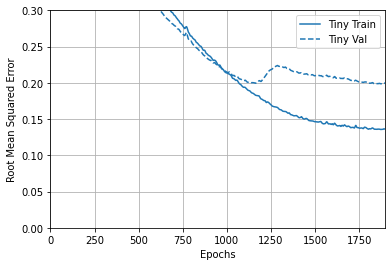

In [63]:
plotter = tfdocs.plots.HistoryPlotter(metric='root_mean_squared_error', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 0.3])

In [65]:
# Let's try a small model
small_model = tf.keras.Sequential([
  layers.Dense(32, activation='elu', input_shape=(FEATURES,)),
  layers.Dense(32, activation='elu'),
  layers.Dense(1)
])

size_histories["Small"] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 2,145
Trainable params: 2,145
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:37.8977,  root_mean_squared_error:6.1561,  val_loss:10.6483,  val_root_mean_squared_error:3.2632,  
...................................................................................................
Epoch: 100, loss:0.0808,  root_mean_squared_error:0.2843,  val_loss:0.1056,  val_root_mean_squared_error:0.3250,  
...................................................

(0.0, 0.3)

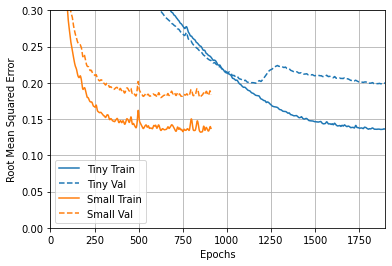

In [66]:
plotter.plot(size_histories, smoothing_std=10)
plt.ylim([0, 0.3])

In [68]:
# Let's try even bigger model
medium_model = tf.keras.Sequential([
  layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
  layers.Dense(64, activation='elu'),
  layers.Dense(64, activation='elu'),
  layers.Dense(1)
])

size_histories["medium"] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:23.3827,  root_mean_squared_error:4.8356,  val_loss:15.6392,  val_root_mean_squared_error:3.9546,  
...................................................................................................
Epoch: 100, loss:0.0229,  root_

(0.0, 0.3)

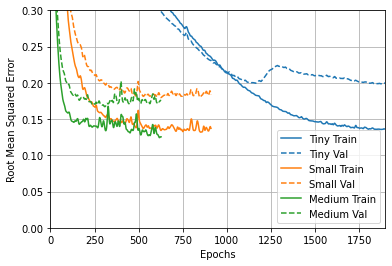

In [69]:
plotter.plot(size_histories, smoothing_std=10)
plt.ylim([0, 0.3])


In [90]:
# maybe even bigger?
large_model = keras.Sequential([
  layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
               activation='elu', input_shape=(FEATURES,)),
  layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
               activation='elu'),
  layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
               activation='elu'),
  layers.Dense(256, kernel_regularizer=regularizers.l2(0.0001),
               activation='elu'),
  layers.Dense(1)
])

size_histories['large_model'] = compile_and_fit(large_model, "sizes/Large", max_epochs=182)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 256)               8448      
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_44 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_45 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 257       
Total params: 206,081
Trainable params: 206,081
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:47.0256,  root_mean_squared_error:6.8515,  val_loss:20.7855,  val_root_mean_squared_error:4.5501,

(0.0, 0.3)

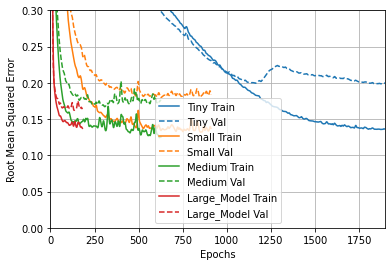

In [91]:
plotter.plot(size_histories)
plt.ylim([0, 0.3])

In [92]:
print("Minimum of large model rmse is:", min(size_histories['large_model'].history['val_root_mean_squared_error']))
print("Minimum of medium model rmse is:", min(size_histories['medium'].history['val_root_mean_squared_error']))

print("Epoch of the smallest val_loss: ", np.argmin(size_histories['large_model'].history['val_root_mean_squared_error']))

Minimum of large model rmse is: 0.15714393556118011
Minimum of medium model rmse is: 0.16589567065238953
Epoch of the smallest val_loss:  159


In [94]:
# make a submission using large model

predictions = large_model.predict(X_test)
predictions = np.exp(predictions) - 1.

submission = X_test.copy()
submission = submission.drop(submission.columns, axis=1)
submission["SalePrice"] = predictions
submission.head()
submission.to_csv("data/submission_2.csv")

In [85]:
# trying medium with regularizers

medium_model = tf.keras.Sequential([
  layers.Dense(64, activation='elu',
               kernel_regularizer=regularizers.l2(0.0001),input_shape=(FEATURES,)),
  layers.Dropout(0.2),
  layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dropout(0.2),
  layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(0.0001)),
  layers.Dense(1)
])

size_histories["medium_reg"] = compile_and_fit(medium_model, 'sizes/Medium_reg')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________

KeyboardInterrupt: 